In [163]:
# import the required libraries
import os
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from keras import optimizers
import keras
# fix the random state
np.random.seed(seed=42)

# load train and test data
train = np.loadtxt(open(os.path.join('input', 'optdigits.tra'), "rb"), delimiter=",")
test =np.loadtxt(open(os.path.join('input', 'optdigits.tes'), "rb"), delimiter=",")

# Define labels for confusion matrix figure
tick_label = ['1','7']

# Slicing features and labels from train and test data
X_train = train[:,:64]
y_train = train[:,64]
X_test = test[:,:64]
y_test = test[:,64]

# Keep only 1s and 7s
# train set
indx_1and7 = [(y_train==1) | (y_train==7)]
X_train = X_train[indx_1and7]
y_train = y_train[indx_1and7]
y_true_train = y_train
y_train = keras.utils.to_categorical(y_train, num_classes=10)


# test set
indx_1and7 = [(y_test==1) | (y_test==7)]
X_test = X_test[indx_1and7]
y_test = y_test[indx_1and7]
print(X_test.shape)

y_true_test = y_test
y_test = keras.utils.to_categorical(y_test, num_classes=10)



# spliting train set into 90% train and 10% validation set
Xtr, Xval, ytr, yval = train_test_split(X_train, y_train, test_size=0.10)


# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
# define a function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print(title)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title)


(361, 64)


In [124]:
def mymodel(n_units, act, lr):
    model = Sequential()
    model.add(Dense(n_units[0], input_dim=64, kernel_initializer='normal', activation=act))
    model.add(Dense(n_units[1], kernel_initializer='normal', activation=act))
    model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

# hyper-parameters
n_units = [[256, 128],[128,128],[128,64]]
acts = ['relu', 'tanh','sigmoid']
lrs = [1e-5, 1e-4, 1e-3, 5e-3]

# hyper-parameters tunning
best_model = None
best_acc = -1
best_lr = None
best_n_units = None
best_act = None

print('Tunning hyper-parameters...')
for units in n_units:
    for act in acts:
        for lr in lrs:
            model = mymodel(n_units=units, act=act, lr=lr)
            model.fit(Xtr, ytr, epochs=10, verbose=0)
            loss, acc = model.evaluate(Xval, yval, verbose=0)
            if acc > best_acc:
                best_model = model
                best_acc = acc
                best_lr = lr
                best_n_units = units
                best_act = act
                
# print best hyper parameters
print('\n',50*'#')
print('Best hyper=parameters: ')
print('Number of units in first hidden layer: {}'.format(best_n_units[0]))
print('Number of units in second hidden layer: {}'.format(best_n_units[1]))
print('Learning rate: {}'.format(best_lr))
print('Activation function: {}'.format(best_act))
print('Best accuracy on validation set: {:.4f}'.format(best_acc))


# train on whole dataset using best model
start = time.time()
best_model.fit(X_train, y_train, epochs=10)
print("Training time: {}".format(time.time() - start))
                

Tunning hyper-parameters...

 ##################################################
Best hyper=parameters: 
Number of units in first hidden layer: 256
Number of units in second hidden layer: 128
Learning rate: 0.0001
Activation function: relu
Best accuracy on validation set: 1.0000
Epoch 1/10
776/776 [==============================] - 0s - loss: 0.0030 - acc: 0.9995     
Epoch 2/10
776/776 [==============================] - 0s - loss: 0.0024 - acc: 0.9995     
Epoch 3/10
776/776 [==============================] - 0s - loss:

In [145]:
# train on whole dataset using best model
start = time.time()
loss, test_acc = best_model.evaluate(X_test, y_test)
print("Test time: {}".format(time.time() - start))

print('Accuracy on test set: {:.4f}'.format(test_acc))

361/361 [==============================] - 0s     
Test time: 0.07198572158813477
Accuracy on test set: 1.0000


In [146]:
# predicted labels
y_pred_train = best_model.predict_classes(X_train, verbose=0)
y_pred_test = best_model.predict_classes(X_test, verbose=0)


Confusion Matrix of Train set
[[389   0]
 [  0 387]]


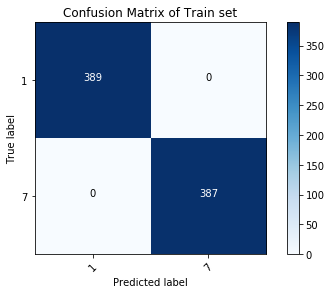

In [156]:
# plot train set confusion matrix
cm_train = confusion_matrix(y_true_train, y_pred_train)
plot_confusion_matrix(cm_train, classes=tick_label,title="Confusion Matrix of Train set")

Confusion Matrix of Test set
[[182   0]
 [  0 179]]


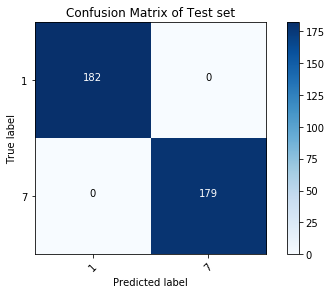

In [157]:
# plot test set confusion matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
plot_confusion_matrix(cm_test, classes=tick_label,title="Confusion Matrix of Test set")